In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, GRU, concatenate, Input, Attention, Flatten
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [3]:
def get_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'medAE: {median_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'MSLE: {mean_squared_log_error(y_true, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

In [4]:
df = pd.read_csv(open('powerconsumption.csv'))
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [5]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    1
PowerConsumption_Zone3    1
dtype: int64

In [6]:
df = df.dropna().reset_index(drop = True)
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [7]:
batched_df = [df[i:i+12] for i in range(0, len(df), 12)]

averages_df = pd.DataFrame(columns = ['PowerConsumption_Zone1'])

for batch in batched_df:
    average_value = batch['PowerConsumption_Zone1'].mean()
    averages_df.loc[len(averages_df)] = [average_value]

print(averages_df)

      PowerConsumption_Zone1
0               26927.594937
1               21447.088607
2               20641.518987
3               20094.683545
4               21255.189873
...                      ...
1056            26830.978725
1057            24234.893617
1058            25206.127660
1059            25499.234043
1060            29420.936169

[1061 rows x 1 columns]


In [8]:
averages_df = averages_df.reset_index(drop = True)
msk = (averages_df.index < len(averages_df) - int(0.2 * len(averages_df)))
df_train = averages_df[msk].copy()
df_test = averages_df[~msk].copy()

<Axes: >

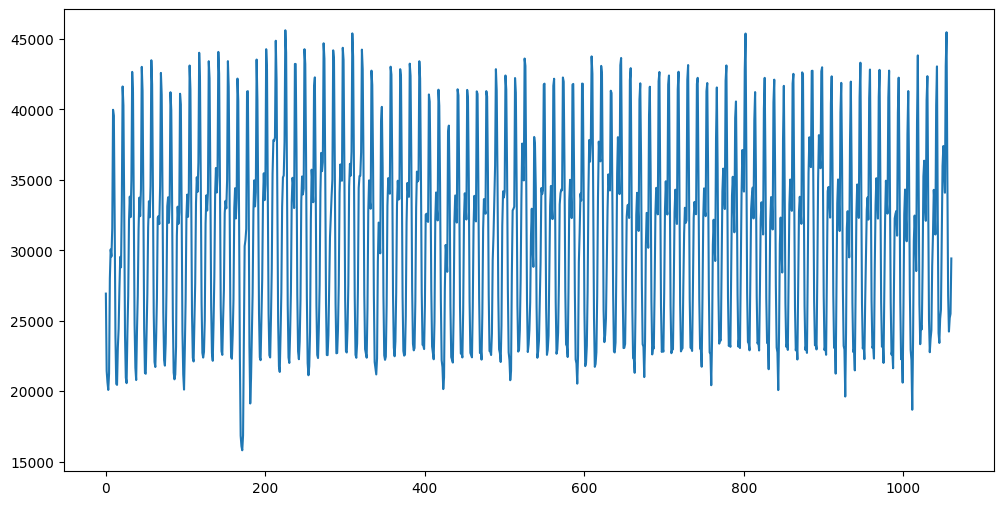

In [9]:
averages_df['PowerConsumption_Zone1'].plot(figsize = (12, 6))

In [10]:
fh = ForecastingHorizon(df_test['PowerConsumption_Zone1'].index, is_relative = False)
fh

ForecastingHorizon([ 849,  850,  851,  852,  853,  854,  855,  856,  857,  858,
       ...
       1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060],
      dtype='int64', length=212, is_relative=False)

MAE: 6096.529907510483
medAE: 5358.638297083335
MSE: 51796329.507433474
MSLE: 0.051450728193402274
MAPE: 0.18955361793362188


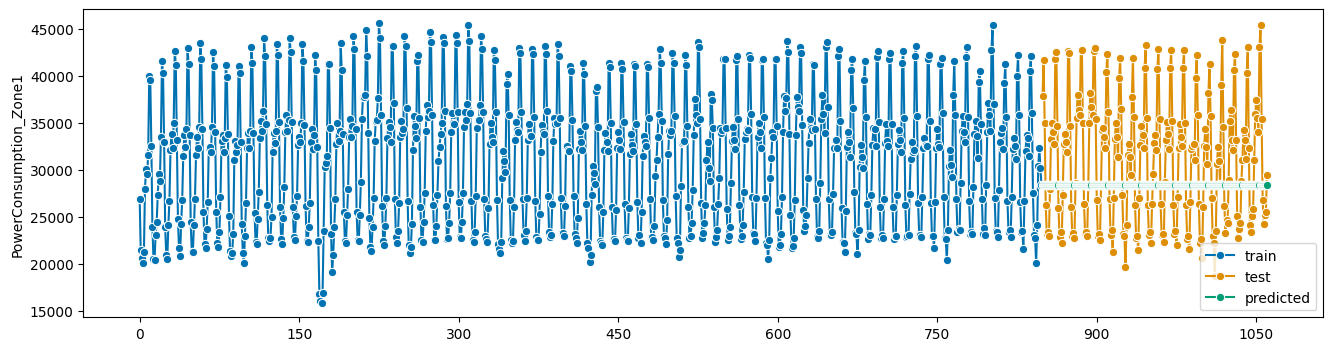

In [11]:
forecaster = NaiveForecaster(strategy = 'last')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 5720.965115470403
medAE: 4921.531915
MSE: 44215989.03260972
MSLE: 0.04687727608464026
MAPE: 0.1932975873549584


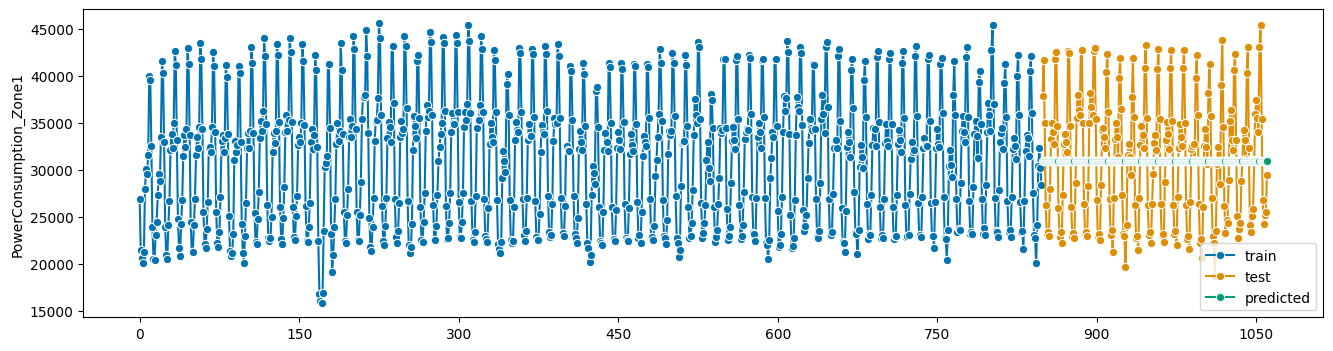

In [12]:
forecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 1631.5336772510482
medAE: 1108.5925004166638
MSE: 4786099.303198604
MSLE: 0.00536276456046328
MAPE: 0.0540970431280468


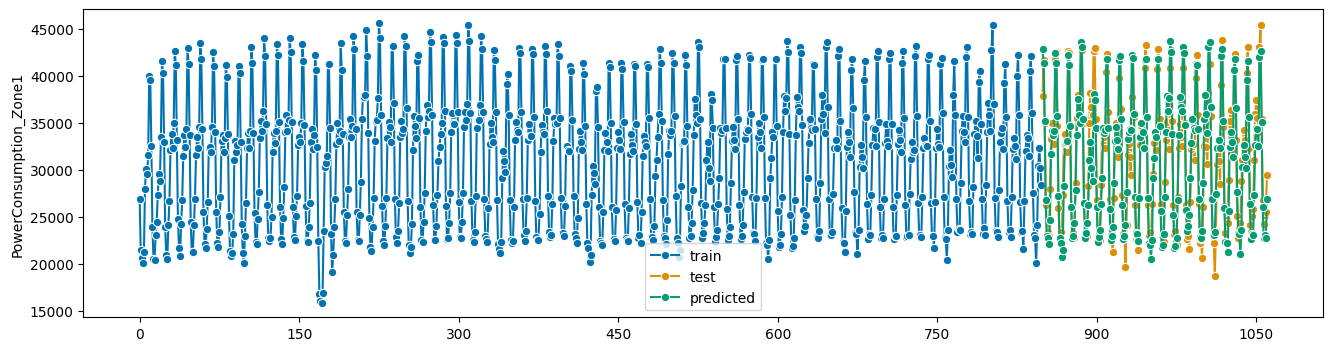

In [13]:
forecaster = NaiveForecaster(strategy = 'last', sp = 30 * 12)
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 896.9433961622113
medAE: 663.8297870833339
MSE: 1494501.889772882
MSLE: 0.0014606966653526495
MAPE: 0.02868173301182632


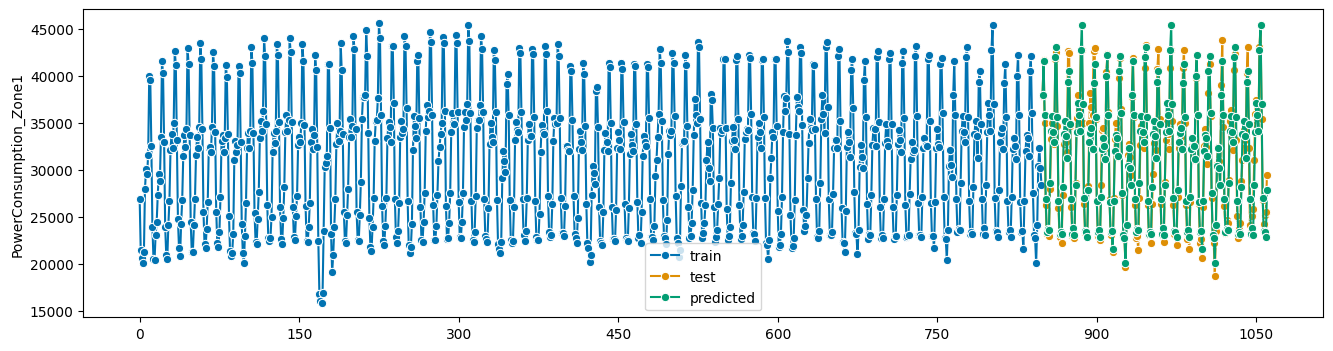

In [14]:
forecaster = NaiveForecaster(strategy = 'last', sp = 7 * 12)
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE: 6094.700185749463
medAE: 5358.638297083335
MSE: 51747732.58051423
MSLE: 0.05140764086899833
MAPE: 0.18954803712226365


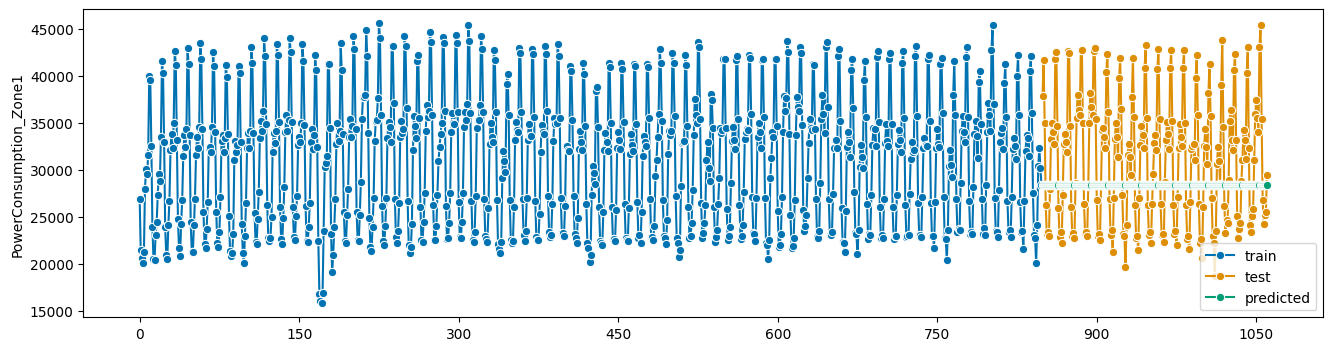

In [15]:
forecaster = ExponentialSmoothing()
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 6096.493530197394
medAE: 5358.638297083335
MSE: 51795361.821131505
MSLE: 0.05144986955557257
MAPE: 0.1895535069796362


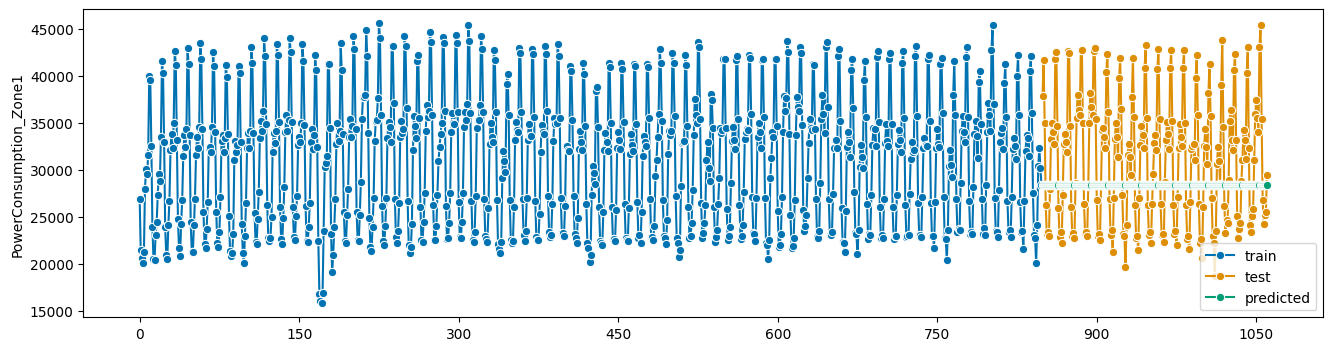

In [16]:
forecaster = AutoETS(auto = True, n_jobs = -1, information_criterion = 'bic')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

In [17]:
forecaster.get_params()

{'additive_only': False,
 'allow_multiplicative_trend': False,
 'auto': True,
 'bounds': None,
 'callback': None,
 'damped_trend': False,
 'dates': None,
 'disp': False,
 'error': 'add',
 'freq': None,
 'full_output': True,
 'ignore_inf_ic': True,
 'information_criterion': 'bic',
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'maxiter': 1000,
 'missing': 'none',
 'n_jobs': -1,
 'random_state': None,
 'restrict': True,
 'return_params': False,
 'seasonal': None,
 'sp': 1,
 'start_params': None,
 'trend': None}

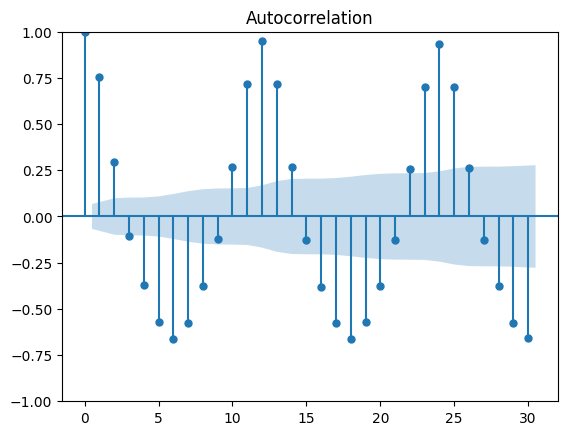

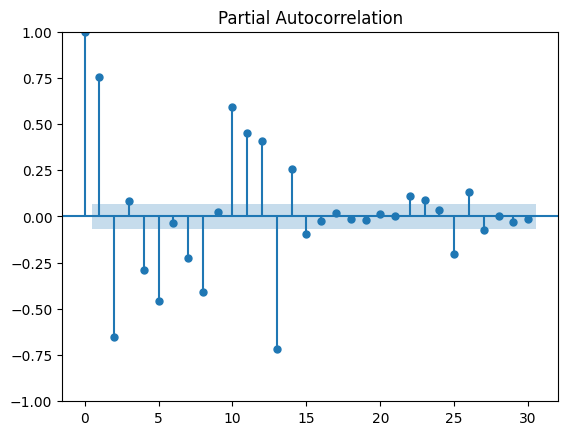

In [18]:
acf_original = plot_acf(df_train['PowerConsumption_Zone1'])
plt.show()

pacf_original = plot_pacf(df_train['PowerConsumption_Zone1'])
plt.show()

In [19]:
adf_test = adfuller(df_train['PowerConsumption_Zone1'])
print(f'p-value: {adf_test[1]}')

p-value: 0.0001685494482965503


In [44]:
seasons = df_train['PowerConsumption_Zone1'][: 12]
seasons.shape

(12,)

<Axes: >

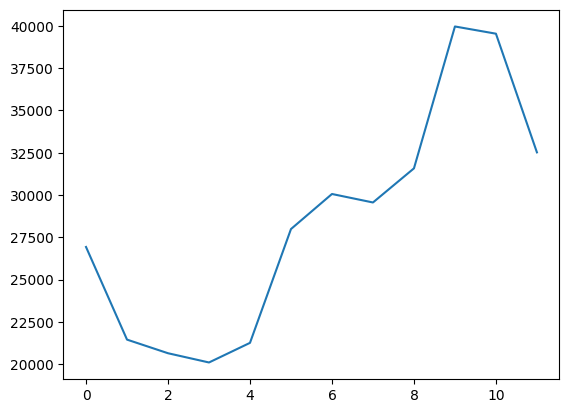

In [28]:
seasons.plot()

In [29]:
adf_test = adfuller(seasons)
print(f'p-value: {adf_test[1]}')

p-value: 0.3158284315998614


In [45]:
seasons = seasons.diff().dropna().reset_index(drop = True)
adf_test = adfuller(seasons)
print(f'p-value: {adf_test[1]}')

p-value: 0.11304047584173482


<Axes: >

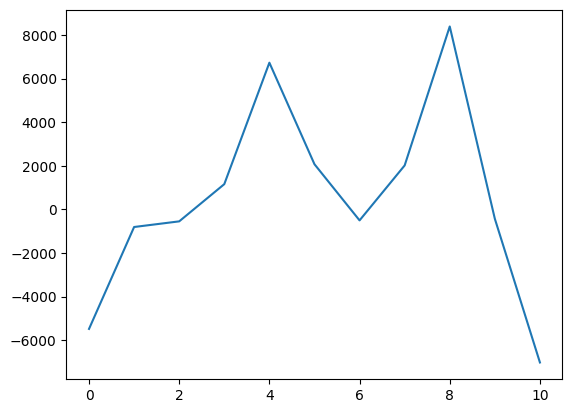

In [46]:
seasons.plot()

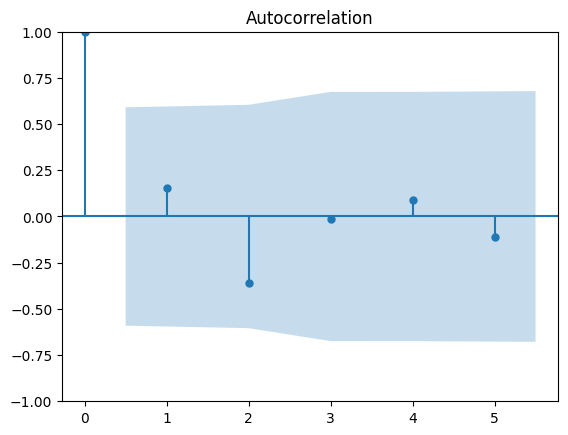

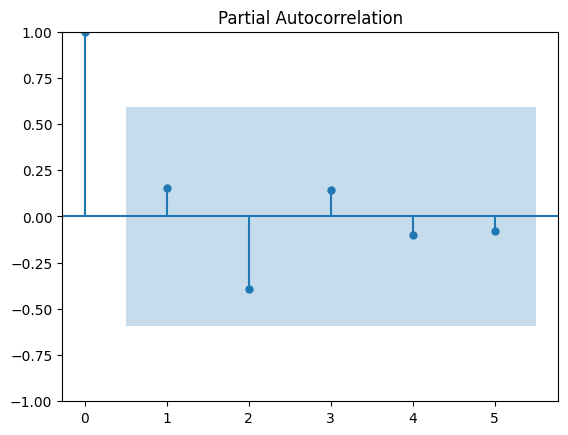

In [47]:
acf_original = plot_acf(seasons)
plt.show()

pacf_original = plot_pacf(seasons)
plt.show()

                                    SARIMAX Results                                     
Dep. Variable:           PowerConsumption_Zone1   No. Observations:                  849
Model:             ARIMA(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -7140.451
Date:                          Thu, 04 Apr 2024   AIC                          14288.902
Time:                                  20:04:52   BIC                          14307.822
Sample:                                       0   HQIC                         14296.155
                                          - 849                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9259      0.020     47.452      0.000       0.888       0.964
ar.L2         -0.3576      0.038     -9.458      0.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

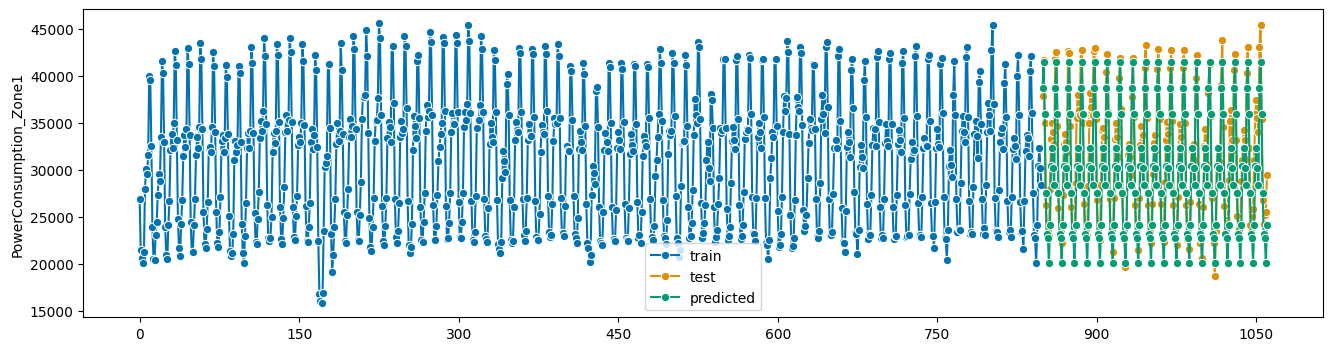

In [52]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (3, 0, 0), seasonal_order = (0, 1, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)
plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

                                    SARIMAX Results                                     
Dep. Variable:           PowerConsumption_Zone1   No. Observations:                  849
Model:             ARIMA(5, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -7135.895
Date:                          Thu, 04 Apr 2024   AIC                          14283.790
Time:                                  20:05:04   BIC                          14312.169
Sample:                                       0   HQIC                         14294.668
                                          - 849                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9251      0.019     49.850      0.000       0.889       0.961
ar.L2         -0.3269      0.035     -9.243      0.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

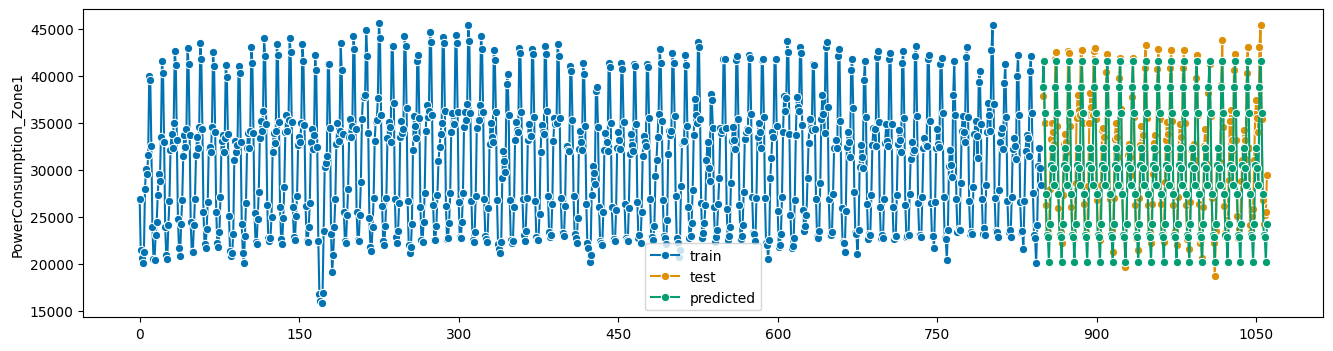

In [53]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (5, 0, 0), seasonal_order = (0, 1, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)
plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

                                    SARIMAX Results                                     
Dep. Variable:           PowerConsumption_Zone1   No. Observations:                  849
Model:             ARIMA(7, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -7131.543
Date:                          Thu, 04 Apr 2024   AIC                          14279.085
Time:                                  20:05:43   BIC                          14316.924
Sample:                                       0   HQIC                         14293.590
                                          - 849                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9147      0.019     47.358      0.000       0.877       0.953
ar.L2         -0.3089      0.037     -8.294      0.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

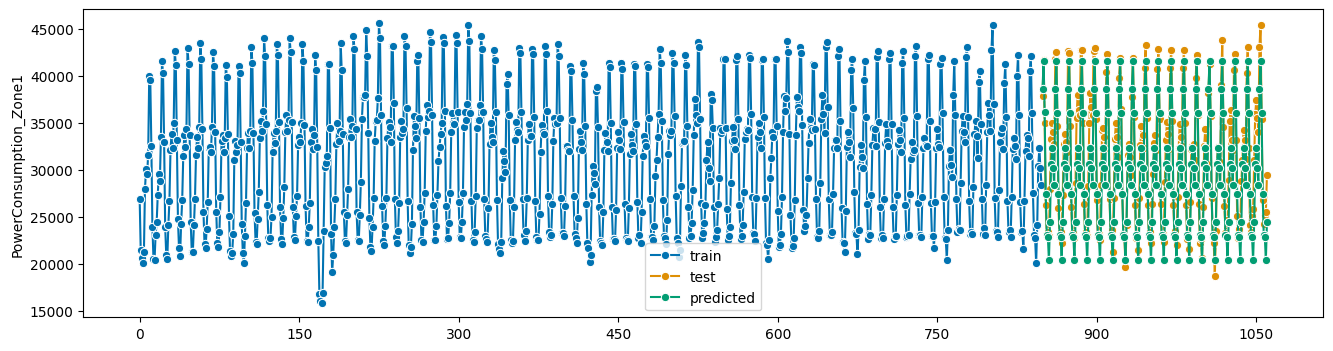

In [55]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (7, 0, 0), seasonal_order = (0, 1, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)
plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

                                    SARIMAX Results                                     
Dep. Variable:           PowerConsumption_Zone1   No. Observations:                  849
Model:             ARIMA(9, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -7129.473
Date:                          Thu, 04 Apr 2024   AIC                          14278.946
Time:                                  20:06:08   BIC                          14326.244
Sample:                                       0   HQIC                         14297.077
                                          - 849                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9153      0.020     46.376      0.000       0.877       0.954
ar.L2         -0.3107      0.038     -8.086      0.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='PowerConsumption_Zone1'>)

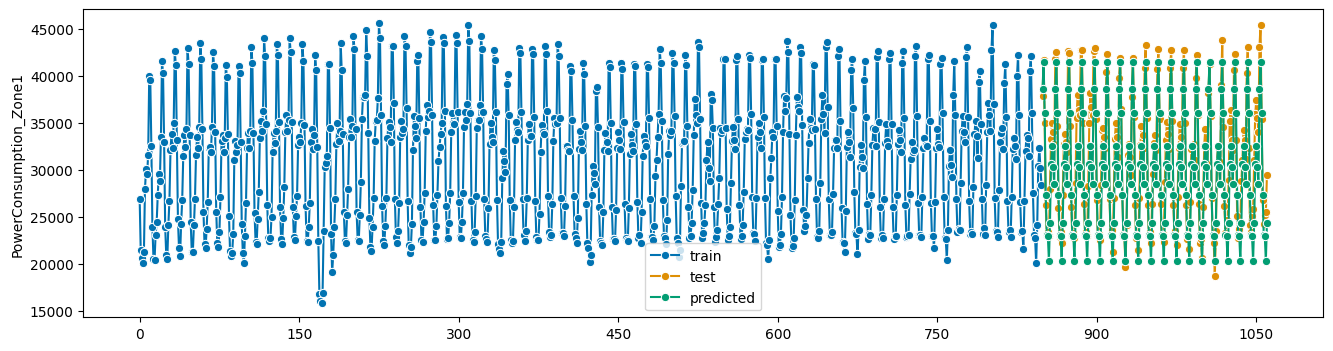

In [56]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (9, 0, 0), seasonal_order = (0, 1, 0, 12))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps = len(df_test['PowerConsumption_Zone1']))
predicted_values = forecast

get_metrics(df_test['PowerConsumption_Zone1'], forecast)
plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], predicted_values, labels = ['train', 'test', 'predicted'])

In [59]:
df = pd.concat([df_train, df_test]).reset_index(drop = True)
df

,PowerConsumption_Zone1
0,26927.594937
1,21447.088607
2,20641.518987
3,20094.683545
4,21255.189873
...,...
1056,26830.978725
1057,24234.893617
1058,25206.127660
1059,25499.234043


Epoch 1/20
103/103 [==============================] - 19s 114ms/step - loss: 0.0619 - mae: 0.2092 - val_loss: 0.0554 - val_mae: 0.2000
Epoch 2/20
103/103 [==============================] - 7s 67ms/step - loss: 0.0424 - mae: 0.1723 - val_loss: 0.0195 - val_mae: 0.1096
Epoch 3/20
103/103 [==============================] - 6s 59ms/step - loss: 0.0169 - mae: 0.1023 - val_loss: 0.0180 - val_mae: 0.1069
Epoch 4/20
103/103 [==============================] - 7s 68ms/step - loss: 0.0131 - mae: 0.0896 - val_loss: 0.0123 - val_mae: 0.0865
Epoch 5/20
103/103 [==============================] - 6s 62ms/step - loss: 0.0099 - mae: 0.0778 - val_loss: 0.0132 - val_mae: 0.0895
Epoch 6/20
103/103 [==============================] - 7s 63ms/step - loss: 0.0089 - mae: 0.0735 - val_loss: 0.0123 - val_mae: 0.0871
Epoch 7/20
103/103 [==============================] - 7s 64ms/step - loss: 0.0077 - mae: 0.0683 - val_loss: 0.0093 - val_mae: 0.0806
Epoch 8/20
103/103 [==============================] - 6s 62ms/step 

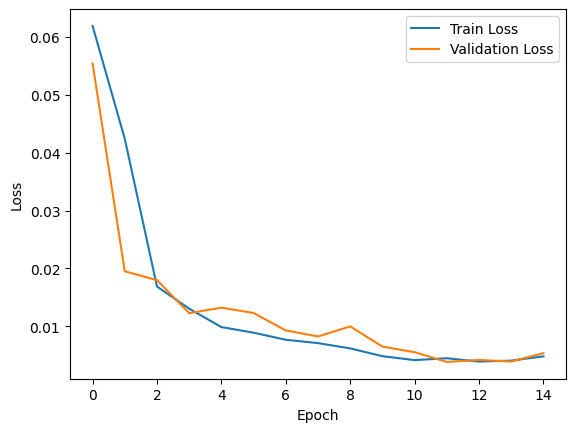

7/7 [==============================] - 1s 21ms/step


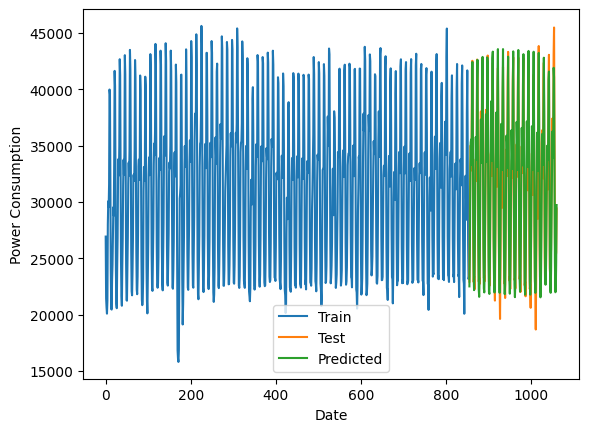

MAE: 1491.867079853695
medAE: 1249.6237541666633
MSE: 3422106.4013596987
MSLE: 0.0038111615092605686
MAPE: 0.04987617612580995


In [64]:
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(df['PowerConsumption_Zone1'].values.reshape(-1, 1))

time_steps = 32
n_neurons = 64

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[ : split], X[split : ]
y_train, y_test = y[ : split], y[split : ]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(LSTM(units = n_neurons, activation = 'elu'))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data = (X_test, y_test), callbacks = [early_stopping])

plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(df.index[ : -len(y_test)], df['PowerConsumption_Zone1'].iloc[ : -len(y_test)], label = 'Train')
plt.plot(df.index[-len(y_test) : ], df['PowerConsumption_Zone1'].iloc[-len(y_test) : ], label = 'Test')
plt.plot(df.index[-len(predicted_values) : ], predicted_values, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

get_metrics(y_test, predicted_values.flatten())

Epoch 1/20
103/103 [==============================] - 21s 122ms/step - loss: 0.0600 - mae: 0.2048 - val_loss: 0.0232 - val_mae: 0.1289
Epoch 2/20
103/103 [==============================] - 10s 101ms/step - loss: 0.0180 - mae: 0.1106 - val_loss: 0.0177 - val_mae: 0.1087
Epoch 3/20
103/103 [==============================] - 14s 132ms/step - loss: 0.0111 - mae: 0.0823 - val_loss: 0.0116 - val_mae: 0.0869
Epoch 4/20
103/103 [==============================] - 13s 127ms/step - loss: 0.0081 - mae: 0.0710 - val_loss: 0.0082 - val_mae: 0.0714
Epoch 5/20
103/103 [==============================] - 13s 123ms/step - loss: 0.0058 - mae: 0.0588 - val_loss: 0.0054 - val_mae: 0.0562
Epoch 6/20
103/103 [==============================] - 12s 116ms/step - loss: 0.0055 - mae: 0.0564 - val_loss: 0.0099 - val_mae: 0.0794
Epoch 7/20
103/103 [==============================] - 12s 116ms/step - loss: 0.0066 - mae: 0.0630 - val_loss: 0.0067 - val_mae: 0.0648
Epoch 8/20
103/103 [==============================] - 1

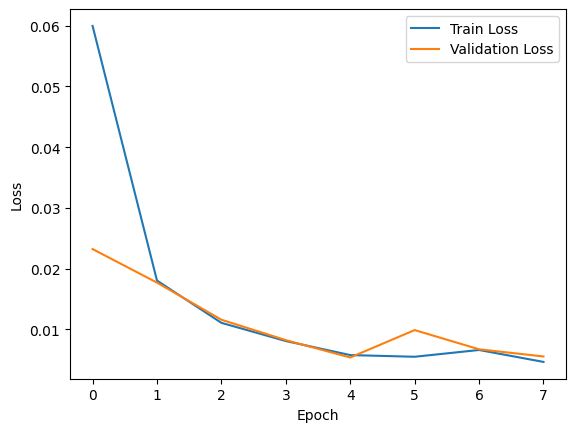

7/7 [==============================] - 2s 26ms/step


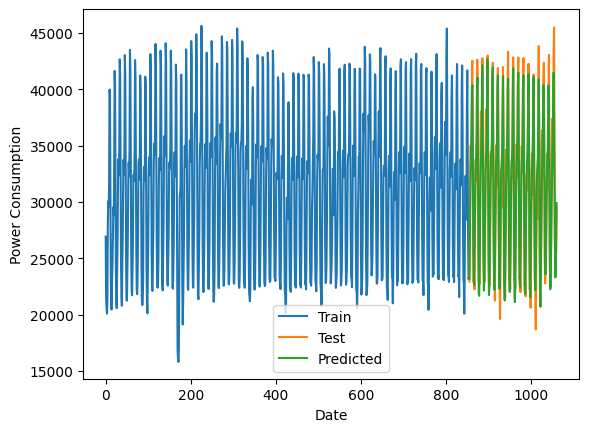

MAE: 1673.9816134499733
medAE: 1329.1722694791679
MSE: 4762053.948690938
MSLE: 0.0052616091003923554
MAPE: 0.0562117340412342


In [65]:
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(df['PowerConsumption_Zone1'].values.reshape(-1, 1))

time_steps = 32
n_neurons = 64

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[ : split], X[split : ]
y_train, y_test = y[ : split], y[split : ]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(GRU(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(GRU(units = n_neurons, return_sequences = True, activation = 'elu'))
model.add(GRU(units = n_neurons, activation = 'elu'))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_data = (X_test, y_test), callbacks = [early_stopping])

plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(df.index[ : -len(y_test)], df['PowerConsumption_Zone1'].iloc[ : -len(y_test)], label = 'Train')
plt.plot(df.index[-len(y_test) : ], df['PowerConsumption_Zone1'].iloc[-len(y_test) : ], label = 'Test')
plt.plot(df.index[-len(predicted_values) : ], predicted_values, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

get_metrics(y_test, predicted_values.flatten())

Epoch 1/20
103/103 [==============================] - 43s 221ms/step - loss: 0.0553 - mae: 0.1932 - val_loss: 0.0330 - val_mae: 0.1517
Epoch 2/20
103/103 [==============================] - 17s 167ms/step - loss: 0.0201 - mae: 0.1167 - val_loss: 0.0187 - val_mae: 0.1116
Epoch 3/20
103/103 [==============================] - 16s 156ms/step - loss: 0.0163 - mae: 0.1028 - val_loss: 0.0160 - val_mae: 0.0977
Epoch 4/20
103/103 [==============================] - 10s 98ms/step - loss: 0.0120 - mae: 0.0862 - val_loss: 0.0137 - val_mae: 0.0982
Epoch 5/20
103/103 [==============================] - 9s 91ms/step - loss: 0.0088 - mae: 0.0742 - val_loss: 0.0100 - val_mae: 0.0801
Epoch 6/20
103/103 [==============================] - 8s 80ms/step - loss: 0.0065 - mae: 0.0629 - val_loss: 0.0063 - val_mae: 0.0602
Epoch 7/20
103/103 [==============================] - 9s 91ms/step - loss: 0.0049 - mae: 0.0552 - val_loss: 0.0072 - val_mae: 0.0680
Epoch 8/20
103/103 [==============================] - 10s 95ms

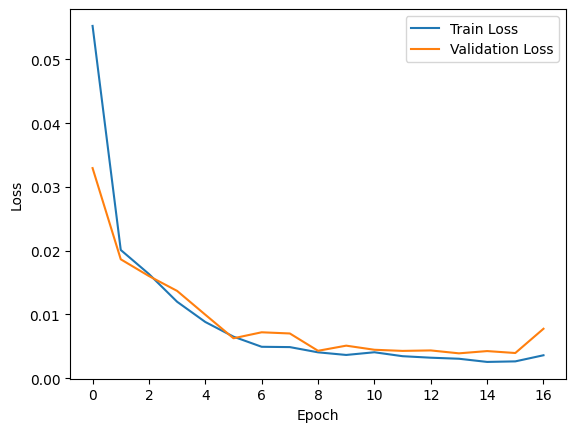

7/7 [==============================] - 2s 20ms/step


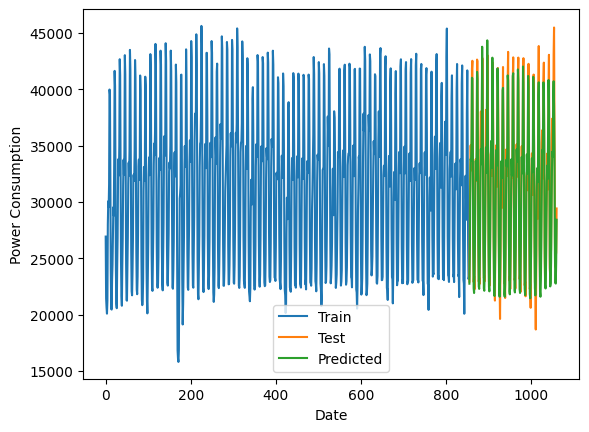

MAE: 1484.9864525623652
medAE: 1213.672622916667
MSE: 3460197.6223376794
MSLE: 0.0035155333058777024
MAPE: 0.0480206943200227


In [68]:
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(df['PowerConsumption_Zone1'].values.reshape(-1, 1))

time_steps = 32
n_neurons = 32

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[ : split], X[split : ]
y_train, y_test = y[ : split], y[split : ]
X_train_rev = X_train[:, ::-1]
X_test_rev = X_test[:, ::-1]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train_rev = X_train_rev.reshape(X_train_rev.shape[0], X_train_rev.shape[1], 1)
X_test_rev = X_test_rev.reshape(X_test_rev.shape[0], X_test_rev.shape[1], 1)

inp1 = Input(shape = ((time_steps, 1)))
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp1)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, activation = 'elu')(direct)

inp2 = Input(shape = ((time_steps, 1)))
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp2)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, activation = 'elu')(reverse)

concat = concatenate([direct, reverse])
concat = Dense(n_neurons * 16, activation = 'elu')(concat)
output = Dense(units = 1)(concat)

model = Model(inputs = [inp1, inp2], outputs = [output])
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit([X_train, X_train_rev], y_train, epochs = 20, batch_size = 8,
                    validation_data = ([X_test, X_test_rev], y_test), callbacks = [early_stopping])

plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predicted_values = model.predict([X_test, X_test_rev])
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(df.index[ : -len(y_test)], df['PowerConsumption_Zone1'].iloc[ : -len(y_test)], label = 'Train')
plt.plot(df.index[-len(y_test) : ], df['PowerConsumption_Zone1'].iloc[-len(y_test) : ], label = 'Test')
plt.plot(df.index[-len(predicted_values) : ], predicted_values, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

get_metrics(y_test, predicted_values.flatten())

Epoch 1/20
103/103 [==============================] - 43s 170ms/step - loss: 0.0539 - mae: 0.1869 - val_loss: 0.0221 - val_mae: 0.1206
Epoch 2/20
103/103 [==============================] - 15s 145ms/step - loss: 0.0185 - mae: 0.1121 - val_loss: 0.0161 - val_mae: 0.1000
Epoch 3/20
103/103 [==============================] - 14s 137ms/step - loss: 0.0112 - mae: 0.0825 - val_loss: 0.0082 - val_mae: 0.0728
Epoch 4/20
103/103 [==============================] - 14s 136ms/step - loss: 0.0072 - mae: 0.0652 - val_loss: 0.0096 - val_mae: 0.0764
Epoch 5/20
103/103 [==============================] - 15s 144ms/step - loss: 0.0072 - mae: 0.0671 - val_loss: 0.0069 - val_mae: 0.0640
Epoch 6/20
103/103 [==============================] - 14s 141ms/step - loss: 0.0064 - mae: 0.0616 - val_loss: 0.0066 - val_mae: 0.0645
Epoch 7/20
103/103 [==============================] - 14s 134ms/step - loss: 0.0060 - mae: 0.0596 - val_loss: 0.0088 - val_mae: 0.0774
Epoch 8/20
103/103 [==============================] - 1

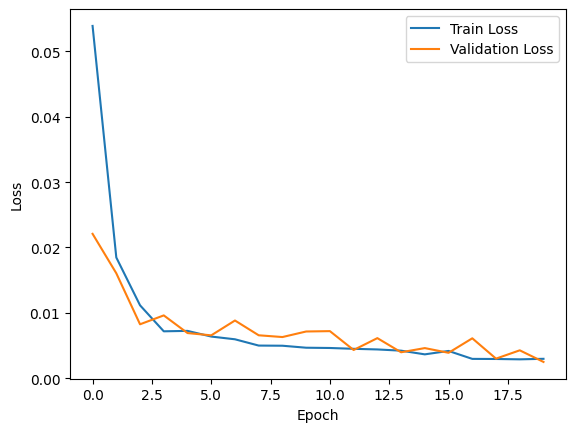

7/7 [==============================] - 2s 30ms/step


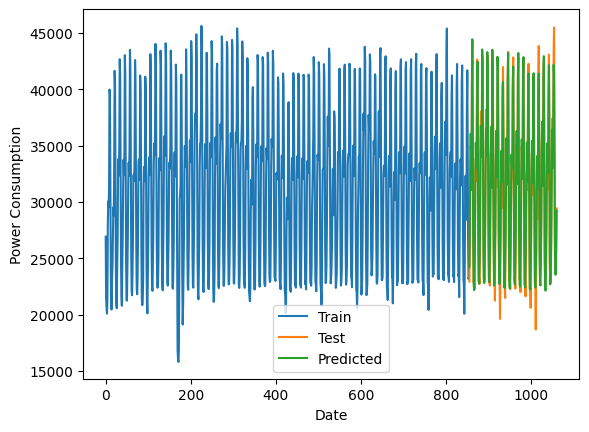

MAE: 1126.1698582005126
medAE: 785.4590061458312
MSE: 2209266.6930131633
MSLE: 0.0026995653967656283
MAPE: 0.038139627057654245


In [87]:
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(df['PowerConsumption_Zone1'].values.reshape(-1, 1))

time_steps = 32
n_neurons = 32

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[ : split], X[split : ]
y_train, y_test = y[ : split], y[split : ]
X_train_rev = X_train[:, ::-1]
X_test_rev = X_test[:, ::-1]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train_rev = X_train_rev.reshape(X_train_rev.shape[0], X_train_rev.shape[1], 1)
X_test_rev = X_test_rev.reshape(X_test_rev.shape[0], X_test_rev.shape[1], 1)

inp1 = Input(shape = ((time_steps, 1)))
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp1)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(direct)
direct = GRU(units = n_neurons, activation = 'elu')(direct)

attention_start = LSTM(units = n_neurons, return_sequences = True, activation = 'elu')(inp1)
attention = LSTM(units = n_neurons, return_sequences = True, activation = 'elu')(attention_start)
attention = LSTM(units = n_neurons, return_sequences = True, activation = 'elu')(attention)
attention = LSTM(units = n_neurons, return_sequences = True, activation = 'elu')(attention)
attention = Attention()([attention_start, attention])
attention = Flatten()(attention)

inp2 = Input(shape = ((time_steps, 1)))
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(inp2)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, return_sequences = True, activation = 'elu')(reverse)
reverse = GRU(units = n_neurons, activation = 'elu')(reverse)

concat = concatenate([direct, reverse, attention])
concat = Dense(n_neurons * 8, activation = 'elu')(concat)
output = Dense(units = 1)(concat)

model = Model(inputs = [inp1, inp2], outputs = [output])
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit([X_train, X_train_rev], y_train, epochs = 20, batch_size = 8,
                    validation_data = ([X_test, X_test_rev], y_test), callbacks = [early_stopping])

plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predicted_values = model.predict([X_test, X_test_rev])
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(df.index[ : -len(y_test)], df['PowerConsumption_Zone1'].iloc[ : -len(y_test)], label = 'Train')
plt.plot(df.index[-len(y_test) : ], df['PowerConsumption_Zone1'].iloc[-len(y_test) : ], label = 'Test')
plt.plot(df.index[-len(predicted_values) : ], predicted_values, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

get_metrics(y_test, predicted_values.flatten())